# Amplitude damping with non-Markovianity witness

This notebook reproduces the non-Markovianity witness in Fig. 3.

The notebook is divided in different sections:

1. [Circuit preparation](#circuit_preparation) where the circuits are prepared 
2. [Simulation](#simulation) where they are simulated locally
3. [Execution on the real device](#execution) where the jobs are sent for execution on the IBM Q devices
4. [Analysis of the result](#analysis) where the results are collected and the plot is made

This notebook was tested with qiskit 0.12.1 and Python 3.7.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
import json
import copy

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ

# Error mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, 
                                                CompleteMeasFitter, 
                                                MeasurementFilter)

# Utility functions
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.jobstatus import JobStatus

In [2]:
# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
#%qiskit_job_watcher

In [3]:
# We use ibmq_vigo
IBMQ.load_account()
backend = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend('ibmq_vigo')

# Local simulator and vector simulator
simulator = Aer.get_backend('qasm_simulator')

### 1. Circuit preparation <a id='circuit_preparation'></a>

In [14]:
from amplitude_damping import *

SHOTS = 200 #8192

# The values for R and corresponding times,
# as well as the observables needed for the witness
observables = ['xx', 'yy', 'zz']
R_values = np.array([0.2, 100.0])
npoints = 200

t_values = {}
for idx, R in enumerate(R_values):
    t_values[str(idx)] = np.linspace(0.0, 6.0 * np.pi / np.sqrt(abs(2.0 * R - 1.0)), npoints)
#t_values = np.linspace(0.0,5.0,npoints)
    
# We create the quantum circuits
q = QuantumRegister(5, name="q")
c = ClassicalRegister(2, name="c")

## Indices of the system, environment and ancillary qubits
sys = 1
env = 2
anc = 3

## Two values of R and thirty values of t for each
## The witness requires measuring three observables per point
circuits = {}
for idx, R in enumerate(R_values):
    circuits[R] = {}
    for observable in observables:
        circuits[R][observable] = []
        for t in t_values[str(idx)]:
            circuits[R][observable].append(initial_state_witness(q, sys, anc)
                               +amplitude_damping_channel_witness(q, c, sys, env, anc, observable, R, t))

# Calibration circuits
cal_circuits, state_labels = complete_meas_cal([sys, anc], q, c)

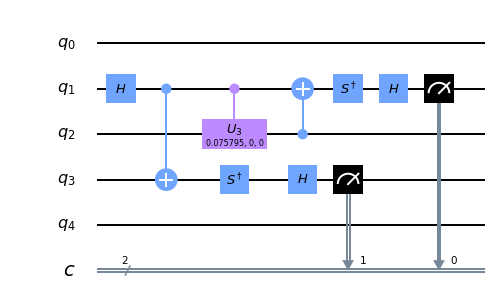

In [15]:
circuits[0.2]['yy'][1].draw(output='mpl')

Drawing of the amplitude damping channel with non-Markovianity witness. The system and the ancillary qubits are measured in the `Y` basis.

### 2. Simulation <a id="simulation"/>

This cell executes locally the (noiseless) simulation of the circuits above.

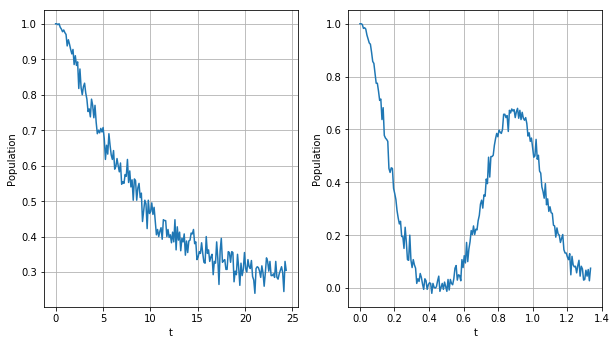

In [16]:
# Execute the circuits on the local simulator
jobs_sim = {}
for R in R_values:
    jobs_sim[R] = {}
    for observable in observables:
        jobs_sim[R][observable] = execute(circuits[R][observable], backend = simulator, shots = SHOTS)

# Analyse the outcomes
## Compute expected values
expected_sim = {}
for idx, R in enumerate(R_values):
    expected_sim[str(idx)] = {}
    for observable in observables:
        expected_sim[str(idx)][observable] = []
        current_job_res = jobs_sim[R][observable].result()
        for i in range(npoints):
            counts = current_job_res.get_counts(i)
            expc = 0.0
            for outcome in counts:
                if outcome[0] == outcome[1]:
                    expc += counts[outcome]/float(SHOTS)
                else:
                    expc -= counts[outcome]/float(SHOTS)
            expected_sim[str(idx)][observable].append(expc)

## Compute witness
witness_sim = {}
for idx, R in enumerate(R_values):
    witness_sim[str(idx)] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected_sim[str(idx)]['xx'][i]-expected_sim[str(idx)]['yy'][i]+expected_sim[str(idx)]['zz'][i])
        witness_sim[str(idx)].append(w)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for idx, R in enumerate(R_values):
    plt.subplot(fig_idx)
    plt.plot(t_values[str(idx)], witness_sim[str(idx)])
    plt.xlabel('t')
    plt.ylabel('Population')
    fig_idx += 1
    plt.grid()

### 2.1 Bokeh bullshit

In [20]:
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource, Slider, CustomJS, Text
from bokeh.plotting import Figure, show
from bokeh.io import output_notebook 

In [21]:
R_values_str = [str(i) for i in range(len(R_values))]

R_values_str_R = ['R = {:.2f}'.format(R) for R in R_values] # truncate to two decimals

# make a dictionary of form {'0': 0.0, '1': 0.2, .. }
R_values_dict = {R_values_str[i]:R_values.round(2)[i] for i,_ in enumerate(R_values)} # rounding to two decimals


In [22]:
ys = witness_sim
rs = {R_values_str[i] : [R_values_str_R[i]] for i,_ in enumerate(R_values)} 
ts = t_values

initial_r = R_values_str[1]

In [24]:
# Wrap the data in two ColumnDataSources

source_visible = ColumnDataSource(data=dict(
    x = ts[initial_r], y = ys[initial_r]))

source_available_x = ColumnDataSource(data=ts)
source_available_y = ColumnDataSource(data=ys)


# Define plot elements
plot = Figure(plot_width=400, plot_height=400, y_range=(-.01, 1))
plot.line('x', 'y', source=source_visible, legend_label="ρ₁₁", line_width=3, line_alpha=0.6)

# Add text
text_source = ColumnDataSource({'r_value': [rs[initial_r]]})
r_available = ColumnDataSource(data=rs)
text = Text(x=0, x_offset=315, y=.8, text='r_value', text_font_size='15pt', text_align='right')
plot.add_glyph(text_source, text)

# Add slider
slider = Slider(value=int(initial_r),
                start=np.min([int(i) for i in ys.keys()]),
                end=np.max([int(i) for i in ys.keys()]),
                step=1,
                show_value = False,
                title = 'R')



# Define CustomJS callback, which updates the plot based on selected function
# by updating the source_visible ColumnDataSource.
slider.callback = CustomJS(
    args=dict(source_visible=source_visible,
              source_available_x=source_available_x,
              source_available_y=source_available_y,
              text_source = text_source,
              r_available = r_available), code="""
        var r_idx = cb_obj.value;
        
        // Get the data from the data sources
        var data_visible = source_visible.data;
        var data_available_x = source_available_x.data;
        var data_available_y = source_available_y.data;
        
        // Change y-axis data according to the selected value
        data_visible.x = data_available_x[r_idx];
        data_visible.y = data_available_y[r_idx];
                
        // text
        text_source.data = {'r_value': [String(r_available.data[r_idx])]};
        
        // Update the plot
        source_visible.change.emit();
        
    """)

layout = column(plot,slider)

output_notebook()

show(layout)

Loading BokehJS ...

### 3. Execution on the real device <a id="execution" />

In [ ]:
# Run the calibration job
calibration_job = execute(cal_circuits, backend, shots=SHOTS)

# Run the circuits and save the jobs
jobs = {}
jobs_data = []
for R in R_values:
    jobs[R] = {}
    for observable in observables:
        jobs[R][observable] = execute(circuits[R][observable], backend = backend, shots = SHOTS)
        job_data = {'jobid': jobs[R][observable].job_id(),
                   'description': 'Amplitude damping channel for R = '+str(R)+'. Non-Markovianity witness observable: '+observable,
                   'metadata': {'t_values': list(t_values[R]), 'R': R, 'observable': observable}}
        jobs_data.append(job_data)

experiment_data = [{
    "backend": backend.name(),
    "calibration": calibration_job.job_id(),
    "description": "Circuits for the simulation of the amplitude damping channel with non-Markovianity witness",
    "jobs": jobs_data
    }]

filename = 'amplitude_damping_witness_{}.json'.format(
            datetime.now().strftime(("%Y_%m_%d-%H_%M")))

with open(filename,'w') as file:
    json.dump(experiment_data, file)

All the information about the experiment is stored in a JSON file called `amplitude_damping_witness_DATETIME.json`.

### 4. Analysis of the results <a id="analysis"/>
#### Instructions:
Use the `filename` variable to load the JSON file containing the experiment information

In [7]:
# List the available experiment files
import glob

print("Available experiment files:")
for f in glob.glob('*.json'):
    print(f)

Available experiment files:
amplitude_damping_2019_11_18-17_15.json
amplitude_damping_witness_2019_11_19-14_48.json


In [8]:
# Load the experiment file
filename = "amplitude_damping_witness_2019_11_19-14_48.json"

with open(filename, 'r') as file:
    experiment_data = json.load(file)
print(experiment_data[0]['description'])
print("Run on", experiment_data[0]['backend'])

Circuits for the simulation of the amplitude damping channel with non-Markovianity witness
Run on ibmq_vigo


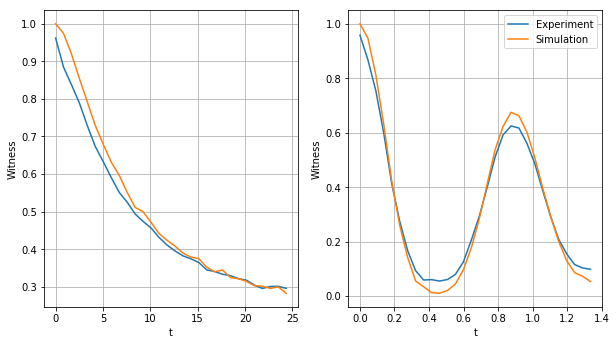

In [9]:
# Get the backend
backend = IBMQ.get_provider(hub='ibm-q-university', group='turku', project='main').get_backend(experiment_data[0]['backend'])

# Use the calibration job to implement the error mitigation
calibration_job = backend.retrieve_job(experiment_data[0]['calibration'])
meas_fitter = CompleteMeasFitter(calibration_job.result(), state_labels)
meas_filter = meas_fitter.filter

# Analyse the outcomes
t_values = {}

## Retrieve jobs
jobs = {}
for job in experiment_data[0]['jobs']:
    R = job['metadata']['R']
    t_values[R] = np.array(job['metadata']['t_values'])
    observable = job['metadata']['observable']
    if R not in jobs:
        jobs[R] = {}
    jobs[R][observable] = backend.retrieve_job(job['jobid'])

## Compute expected values
expected = {}
for R in R_values:
    expected[R] = {}
    for observable in observables:
        expected[R][observable] = []
        current_job_res = jobs[R][observable].result()
        mitigated_res = meas_filter.apply(current_job_res)
        for i in range(npoints):
            counts = mitigated_res.get_counts(i)
            expc = 0.0
            for outcome in counts:
                if outcome[0] == outcome[1]:
                    expc += counts[outcome]/float(SHOTS)
                else:
                    expc -= counts[outcome]/float(SHOTS)
            expected[R][observable].append(expc)

## Compute witness
witness = {}
for R in R_values:
    witness[R] = []
    for i in range(npoints):
        w = 0.25*(1.0+expected[R]['xx'][i]-expected[R]['yy'][i]+expected[R]['zz'][i])
        witness[R].append(w)

# Plot the results
fig_idx = 221
plt.figure(figsize=(10,12))
for R in R_values:
    plt.subplot(fig_idx)
    plt.plot(t_values[R], witness[R], label='Experiment')
    plt.plot(t_values[R], witness_sim[R], label='Simulation')
    plt.xlabel('t')
    plt.ylabel('Witness')
    fig_idx += 1
    plt.grid()
plt.legend();

The job contains info on the gate and measurement error rates

In [10]:
jobs[0.2]['zz'].properties().qubits

[[Nduv(date=datetime.datetime(2019, 11, 19, 8, 3, 37, tzinfo=tzutc()), name='T1', unit='µs', value=93.93515779118157),
  Nduv(date=datetime.datetime(2019, 11, 7, 7, 10, 41, tzinfo=tzutc()), name='T2', unit='µs', value=14.6521525510656),
  Nduv(date=datetime.datetime(2019, 11, 19, 9, 53, 43, tzinfo=tzutc()), name='frequency', unit='GHz', value=4.795984839077308),
  Nduv(date=datetime.datetime(2019, 11, 19, 7, 52, 47, tzinfo=tzutc()), name='readout_error', unit='', value=0.029000000000000026),
  Nduv(date=datetime.datetime(2019, 11, 19, 7, 52, 47, tzinfo=tzutc()), name='prob_meas0_prep1', unit='', value=0.040000000000000036),
  Nduv(date=datetime.datetime(2019, 11, 19, 7, 52, 47, tzinfo=tzutc()), name='prob_meas1_prep0', unit='', value=0.018)],
 [Nduv(date=datetime.datetime(2019, 11, 19, 8, 3, 37, tzinfo=tzutc()), name='T1', unit='µs', value=91.01952536257376),
  Nduv(date=datetime.datetime(2019, 11, 19, 8, 5, 16, tzinfo=tzutc()), name='T2', unit='µs', value=106.99772141102278),
  Nduv(d

In [11]:
jobs[0.2]['zz'].properties().gates

[Gate(gate='id', name='id_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 19, 8, 16, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0005064148356984124), Nduv(date=datetime.datetime(2019, 11, 19, 9, 53, 43, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u1', name='u1_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 19, 8, 16, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0), Nduv(date=datetime.datetime(2019, 11, 19, 9, 53, 43, tzinfo=tzutc()), name='gate_length', unit='ns', value=0.0)], qubits=[0]),
 Gate(gate='u2', name='u2_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 19, 8, 16, 41, tzinfo=tzutc()), name='gate_error', unit='', value=0.0005064148356984124), Nduv(date=datetime.datetime(2019, 11, 19, 9, 53, 43, tzinfo=tzutc()), name='gate_length', unit='ns', value=35.55555555555556)], qubits=[0]),
 Gate(gate='u3', name='u3_0', parameters=[Nduv(date=datetime.datetime(2019, 11, 19, 8, 16, 41, tzin